In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import GaussianKernelSDE
from sdebridge.utils import *
from sdebridge.plotting import *
from sdebridge.data_processing import sample_ellipse

plt.style.use('ggplot')

### Variable Q

### 2 Landmarks

In [3]:
sde_config = ConfigDict()
sde_config.dim = 4
sde_config.N = 100
sde_config.alpha = 1.0
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0])
XT = jnp.array([-0.5, 1.0, 0.5, 1.0])

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=16
)

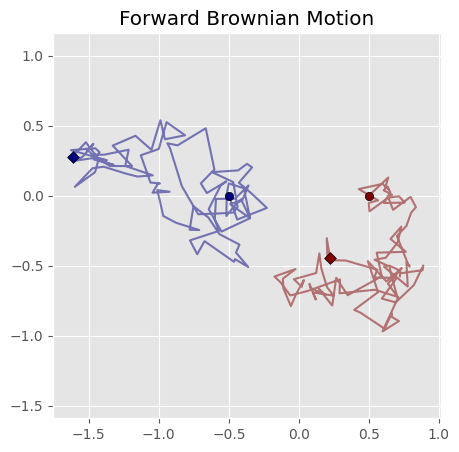

In [5]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [13]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:18<00:00,  5.42epoch/s, Epoch=100, loss=4.8984]


In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           num_batches=4)

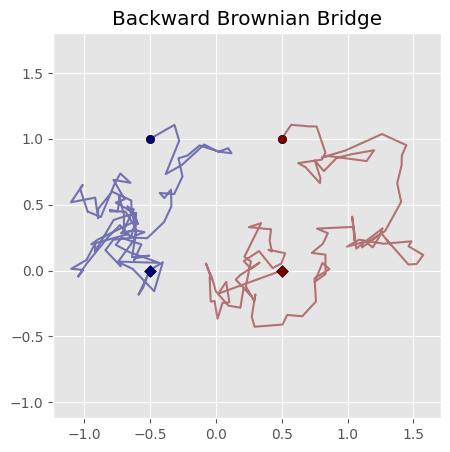

In [17]:
for i in range(1):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [18]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:24<00:00,  4.07epoch/s, Epoch=100, loss=4.8080]


In [19]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         num_batches=4)

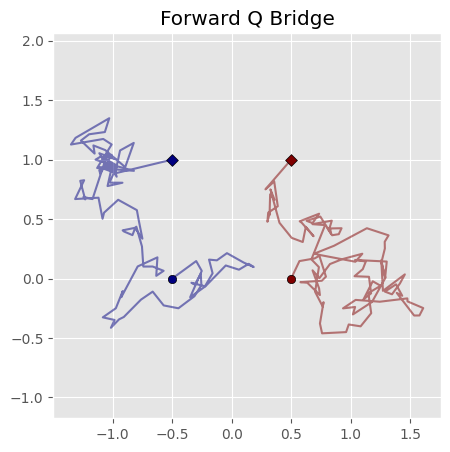

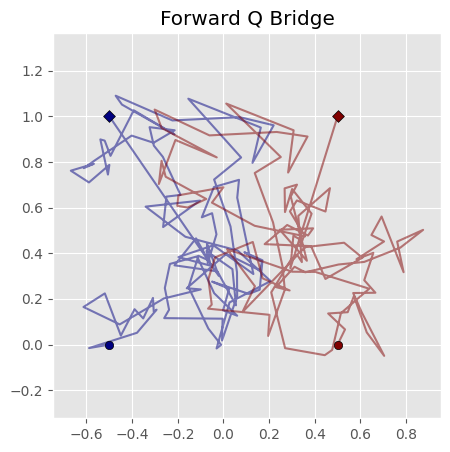

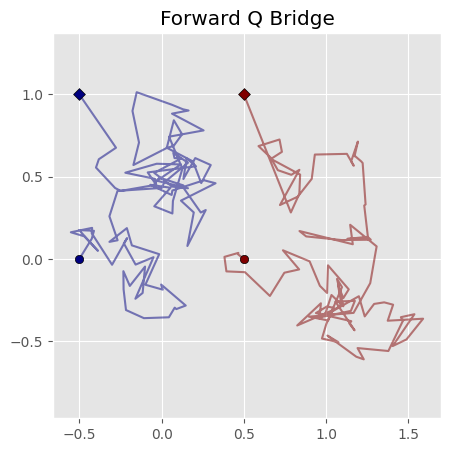

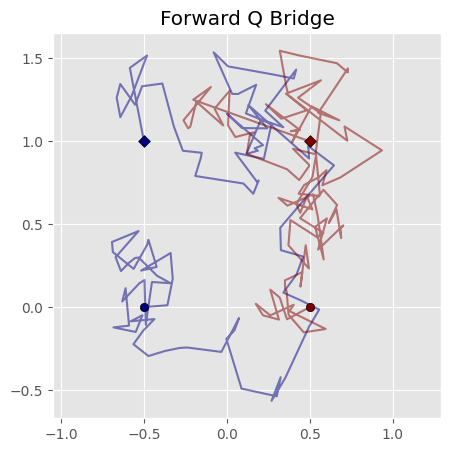

In [20]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 4 Landmarks

In [27]:
sde_config = ConfigDict()
sde_config.dim = 8
sde_config.N = 100
sde_config.alpha = 0.5
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0, 0.5, 1.0, -0.5, 1.0])
XT = jnp.array([-0.5, 1.0, 0.5, 1.0, 0.5, 2.0, -0.5, 2.0])

In [22]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=1
)

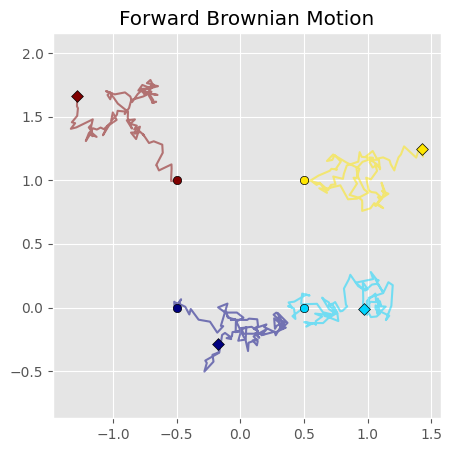

In [23]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [48]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'tanh',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 500,
                 "num_batches_per_epoch": 128,
                 "learning_rate": 2e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 500/500 [00:52<00:00,  9.60epoch/s, Epoch=500, loss=30.3696]


In [49]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           num_batches=4)

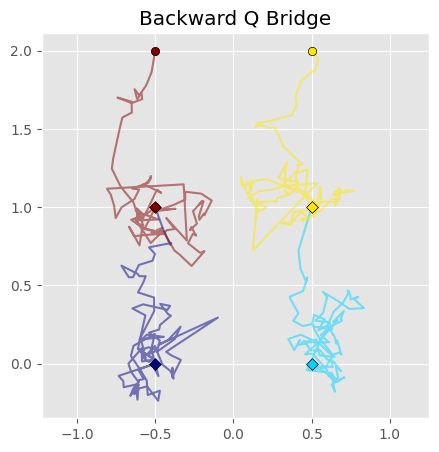

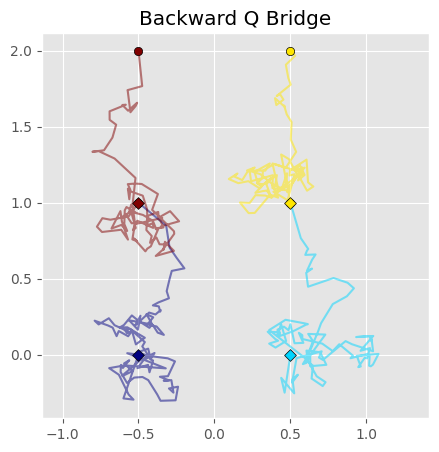

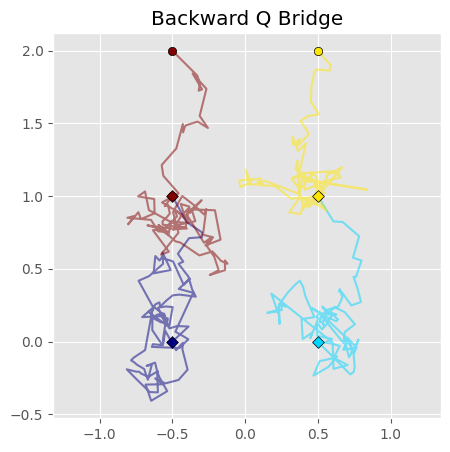

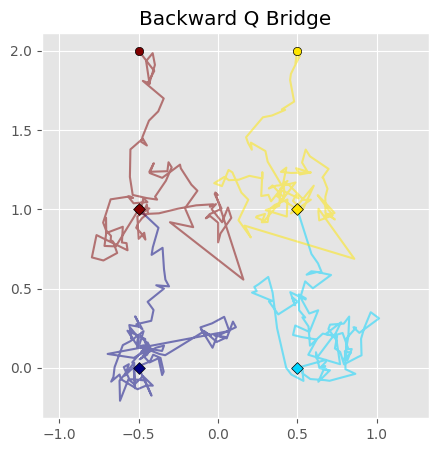

In [50]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [56]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'tanh',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 500,
                 "num_batches_per_epoch": 128,
                 "learning_rate": 2e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params)

Training: 100%|██████████| 500/500 [01:03<00:00,  7.91epoch/s, Epoch=500, loss=35.8844]


In [57]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         num_batches=4)

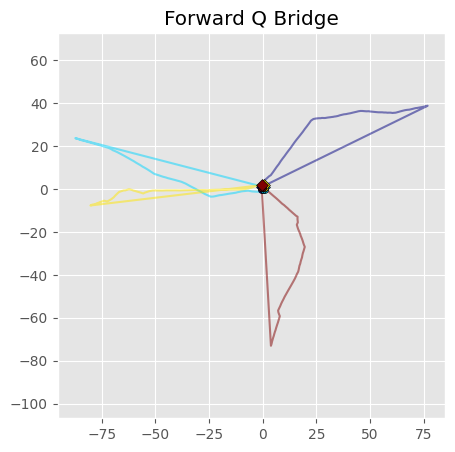

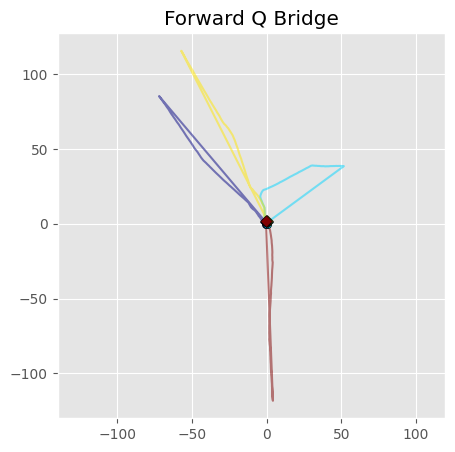

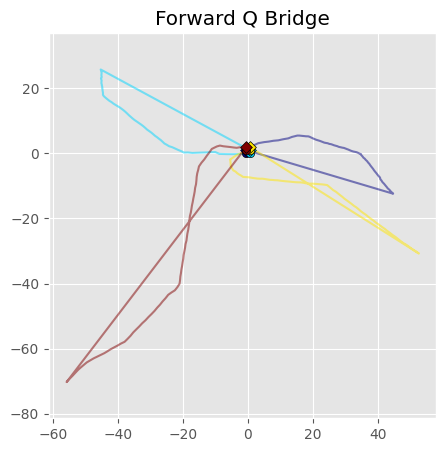

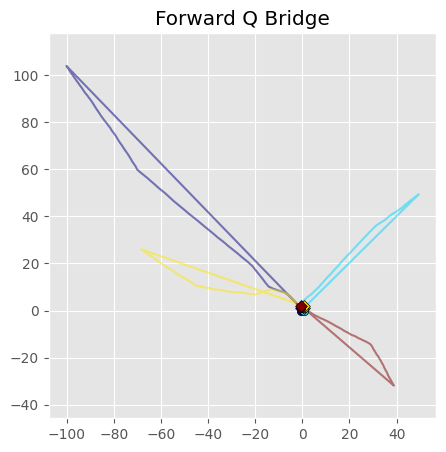

In [58]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 8 Landmarks

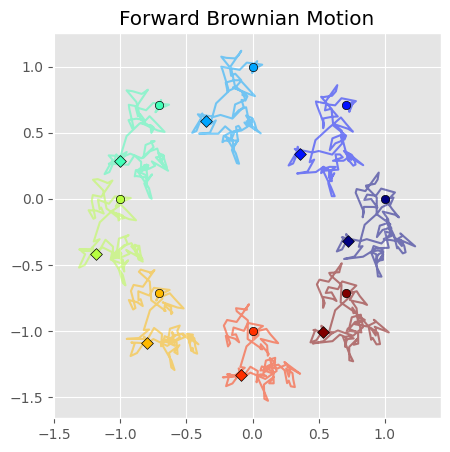

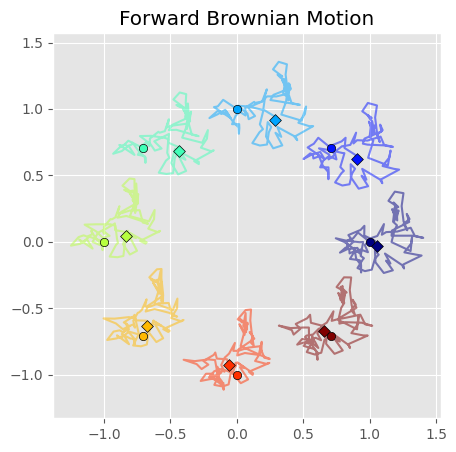

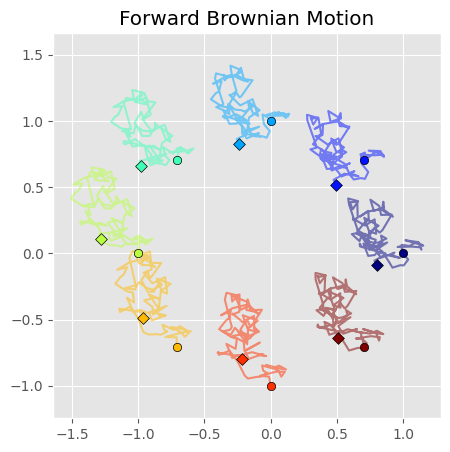

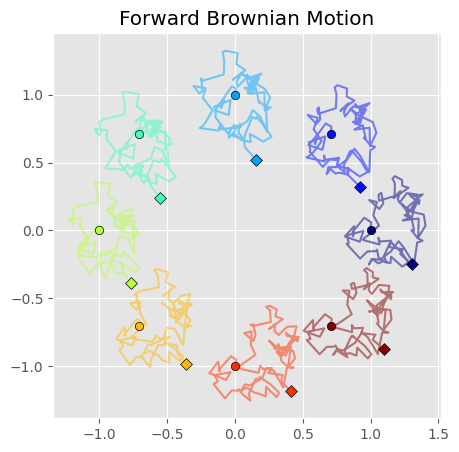

In [25]:
d = 16
alpha = 0.5
sigma = 2.0
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
XT = sample_ellipse(num_points=d//2, scale=1.2, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng_key=rng_key,
    num_batches=4
)

for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [16]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 16,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key,
                                     )

Training: 100%|██████████| 50/50 [01:24<00:00,  1.70s/epoch, Epoch=50, loss=4.8221]


In [26]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)

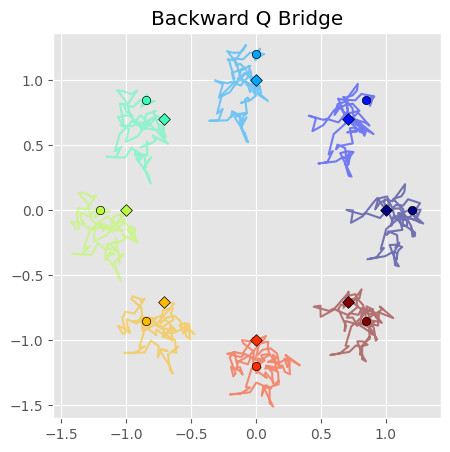

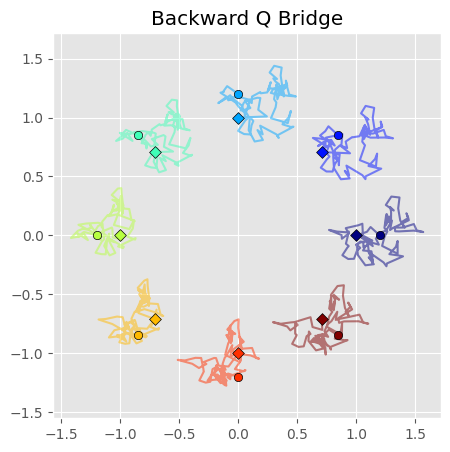

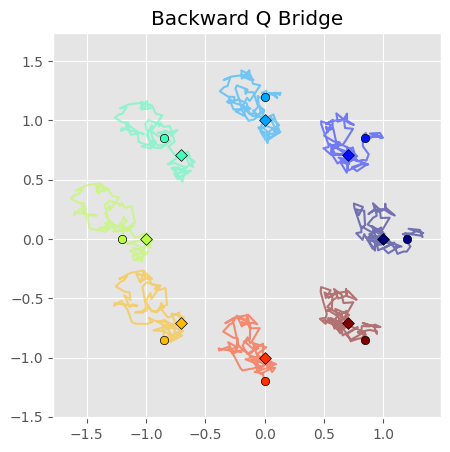

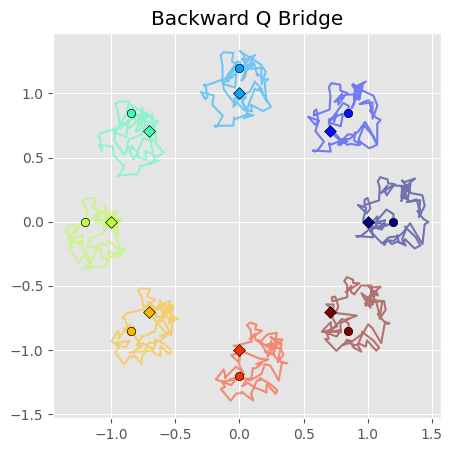

In [27]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [28]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64, 64],
                "decoder_layer_dims": [64, 64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 16,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng_key=rng_key)

Training: 100%|██████████| 50/50 [04:42<00:00,  5.66s/epoch, Epoch=50, loss=4.3352]


In [29]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng_key=rng_key,
                                                         num_batches=4)

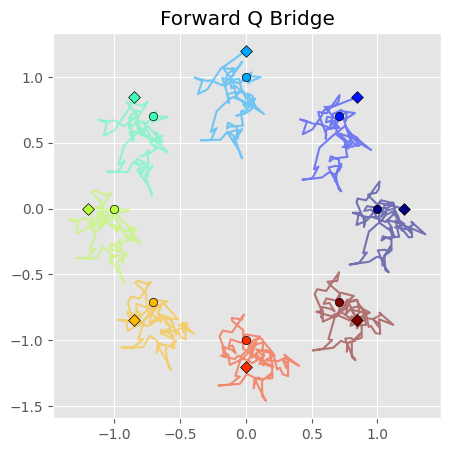

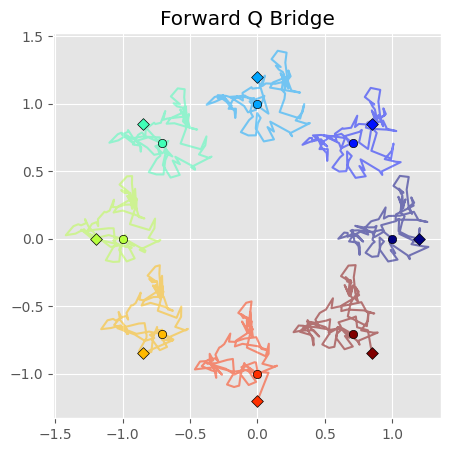

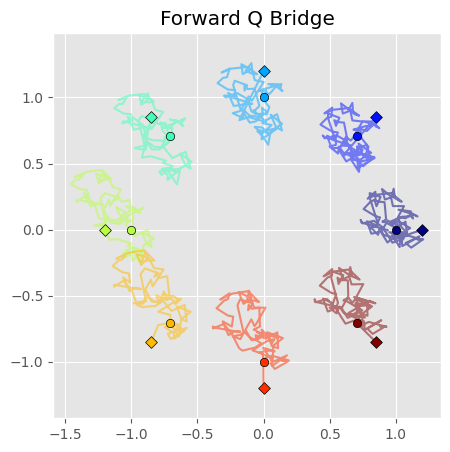

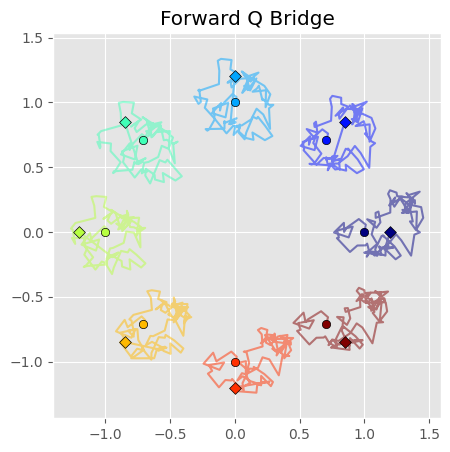

In [30]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 16 Landmarks

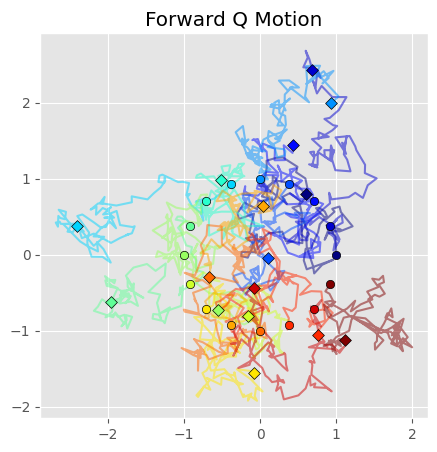

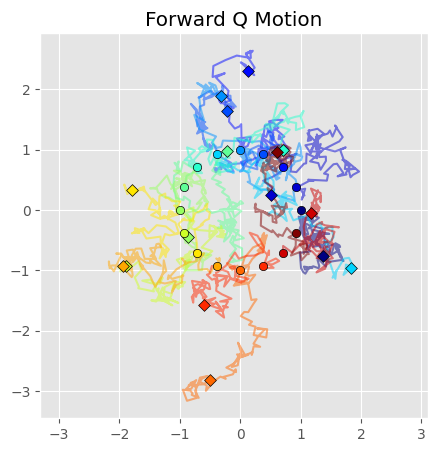

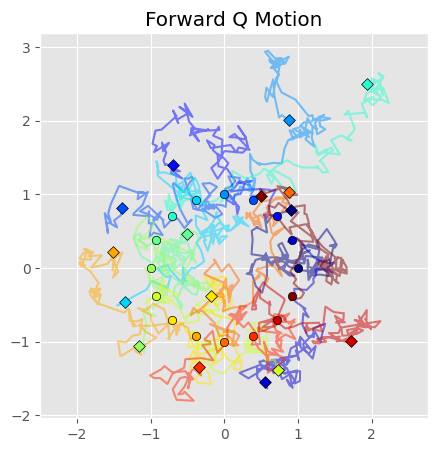

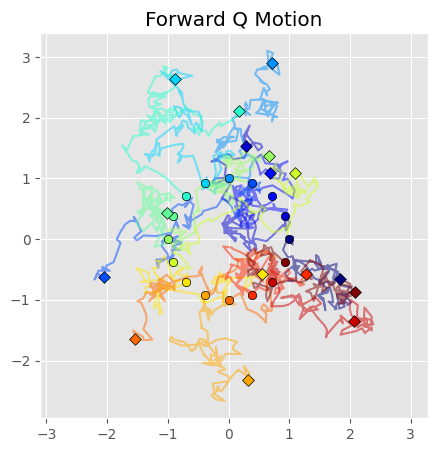

In [13]:
d = 32
alpha = 1.0
sigma = 0.01
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
XT = sample_ellipse(num_points=d//2, scale=2.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng_key=rng_key,
    num_batches=4
)

for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Q Motion")

In [9]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 8,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key,
                                     )

Training: 100%|██████████| 50/50 [01:17<00:00,  1.56s/epoch, Epoch=50, loss=15.4760]


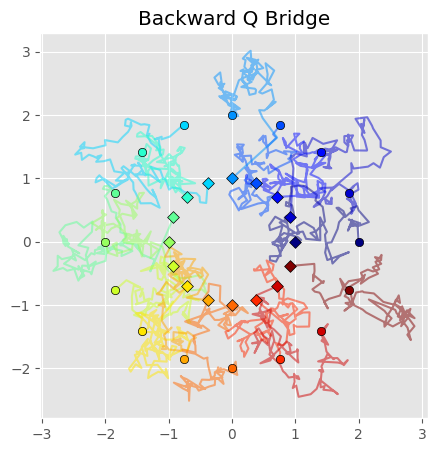

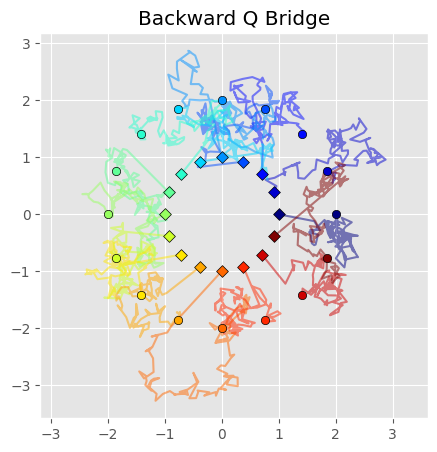

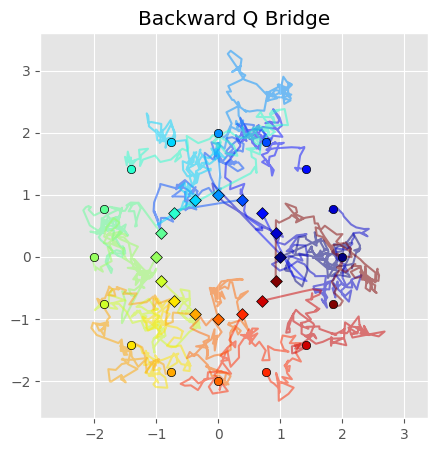

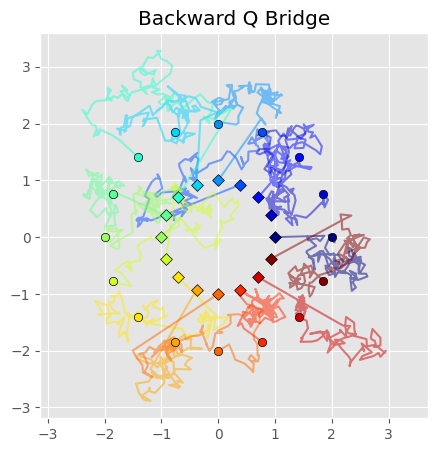

In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")